# Basic functionality

## Input data

We start by importing tobac:

In [1]:
import tobac

Tobac works with a Python package called *xarray*, which introduces *DataArrays*. In a nutshell these are *Numpy*-arrays with labels. For a more extensive description have a look at the [Documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray).
    
There are several utilities implemented in tobac to create simple examples of such arrays. In this tutorial we will use this function *make_simple_sample_data_2D()*:

In [23]:
test_data = tobac.testing.make_simple_sample_data_2D()
test_data

<xarray.DataArray 'w' (time: 100, y: 50, x: 100)>
[500000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T13:39:00
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1

As you can see our data describes a field called 'w' with the unit m/s at 100, 50 and 100 datapoints of time, x and y. Additionally the data contains the latitude and longitude coordniates of the field values. To access the actual data we can use

In [14]:
test_data.data

array([[[3.67879441e+00, 4.04541885e+00, 4.40431655e+00, ...,
         2.22319774e-16, 9.26766698e-17, 3.82489752e-17],
        [4.04541885e+00, 4.44858066e+00, 4.84324569e+00, ...,
         2.44475908e-16, 1.01912721e-16, 4.20608242e-17],
        [4.40431655e+00, 4.84324569e+00, 5.27292424e+00, ...,
         2.66165093e-16, 1.10954118e-16, 4.57923372e-17],
        ...,
        [6.45813368e-03, 7.10174389e-03, 7.73178977e-03, ...,
         3.90282972e-19, 1.62694148e-19, 6.71461808e-20],
        [4.43860604e-03, 4.88095244e-03, 5.31397622e-03, ...,
         2.68237303e-19, 1.11817944e-19, 4.61488502e-20],
        [3.02025230e-03, 3.32124719e-03, 3.61589850e-03, ...,
         1.82522243e-19, 7.60865909e-20, 3.14020145e-20]],

       [[2.77002707e+00, 3.10141076e+00, 3.43788719e+00, ...,
         9.59477405e-16, 4.07234329e-16, 1.71124056e-16],
        [3.07177968e+00, 3.43926262e+00, 3.81239306e+00, ...,
         1.06399798e-15, 4.51596358e-16, 1.89765437e-16],
        [3.37250939e+00, 

which is then just an array of numbers of the described shape.

To vizualize the data we can plot single timeframes with imshow of matplotlib:

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

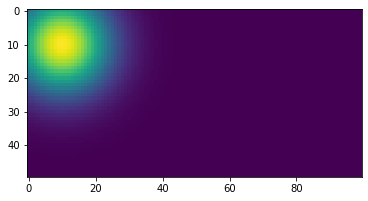

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(test_data.data[0])
plt.colorbar

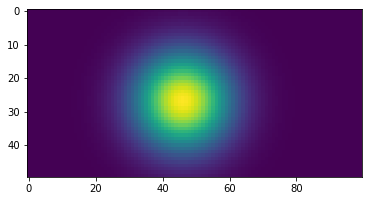

In [21]:
plt.imshow(test_data.data[20])

This tells as that our data is a single wandering blob, which is what we are going the analyze with tobac now.

## Feature detection

The first step is the identification of features. This esentially means finding the maxima or minima of the data.

To use the according functions of tobac we need to specify:

- the thresholds below/above the features are detected
- the spacing of our data

The spacing of the temporal and spatial dimension can be extracted from the data using a build-in utility:

In [30]:
dxy, dt = tobac.utils.get_spacings(test_data)

To get an idea of which order of magnitude our thresholds should be, we check the maximum of our data:

In [35]:
test_data.max()

<xarray.DataArray 'w' ()>
array(10.)

Since we know that our data will only have one maximum it is reasoable to choose 9 as our threshold, but keep in mind that we could also add multiple values here if our data would be more complex.

In [38]:
threshold = 9

Now we are ready to apply the feature detection algorithm. Notice that this is a minimal input. The function has several other option we will cover in later tutorials.

In [45]:
features = tobac.themes.tobac_v1.feature_detection_multithreshold(test_data, dxy, threshold)

    frame  idx     hdim_1     hdim_2  num  threshold_value  feature  \
0       0    1  10.000000  10.000000   69                9        1   
1       1    1  10.939394  11.848485   66                9        2   
2       2    1  11.707692  13.661538   65                9        3   
3       3    1  12.569231  15.353846   65                9        4   
4       4    1  13.200000  17.107692   65                9        5   
5       5    1  14.184615  19.000000   65                9        6   
6       6    1  15.060606  20.848485   66                9        7   
7       7    1  15.953125  22.765625   64                9        8   
8       8    1  16.707692  24.338462   65                9        9   
9       9    1  17.676923  26.169231   65                9       10   
10     10    1  18.184615  28.000000   65                9       11   
11     11    1  19.171875  29.828125   64                9       12   
12     12    1  20.046875  31.765625   64                9       13   
13    

Lets inpects the resulting object:

In [49]:
features

<xarray.Dataset>
Dimensions:                  (index: 51)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
Data variables: (12/13)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 45 46 47 48 49 50
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    hdim_1                   (index) float64 10.0 10.94 11.71 ... 48.15 48.6
    hdim_2                   (index) float64 10.0 11.85 13.66 ... 97.23 98.2
    num                      (index) int64 69 66 65 65 65 65 ... 39 34 23 13 5
    threshold_value          (index) int64 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9
    ...                       ...
    time                     (index) object 2000-01-01 12:00:00 ... 2000-01-0...
    timestr                  (index) object '2000-01-01 12:00:00' ... '2000-0...
    projection_y_coordinate  (index) float64 1e+04 1.094e+04 ... 4.86e+04
    projection_x_coordinate  (index) float64 1e+04 1.185e+04 ... 9.82e+04
    latitude                 (index) object 24.1 24.12 24.14 ... 24.97 24.98
    longitude                (index) object 150.1 150.1 150.1 ... 150.5 150.5

The ouputs tells us that features were found in 51 **frame**s  (index 0 to 50) of our data. The variable **idx** is 1 for every frames, which means that only 1 feature was found in every time step, as we expected. **hdim_1** and **hdim2** are the position of this feature with respect to the y and x-indices.

To vizualize this let's create masks for the frames we inspected before:

In [71]:
mask_1 = features['frame'] == 0
mask_2 = features['frame'] == 20

Now we can scatter the detected features onto the pictures we plotted:

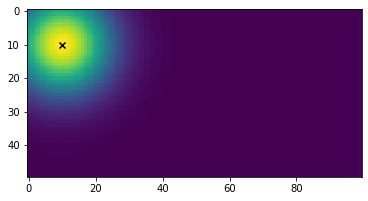

In [75]:
plt.imshow(test_data.data[0])
plt.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], color = 'black', marker = 'x')

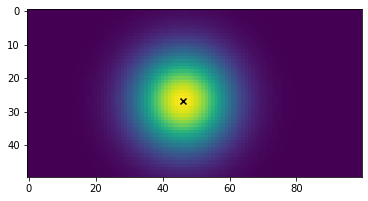

In [76]:
plt.imshow(test_data.data[20])
plt.scatter(features.where(mask_2)['hdim_2'], features.where(mask_2)['hdim_1'], color = 'black', marker = 'x')

variable num?

The other variables are self-explanatory?

## Segementation

The step after the feature detection is the segmentation of the data. This means we find the area sorounding our features belonging to the same cluster. Logically, we now need the detected features as an additional input.

In [106]:
mask, features_test = tobac.themes.tobac_v1.segmentation(features, test_data, dxy, threshold=9)

<xarray.DataArray 'w' (time: 100, y: 50, x: 100)>
[500000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T13:39:00
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1


As indicated by the name the first returned object is a boolean mask, which is true for all segemnts belonging to features. The second output are again the features of the field.

In [96]:
mask

<xarray.DataArray 'segmentation_mask' (time: 100, y: 50, x: 100)>
[500000 values with dtype=int32]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T13:39:00
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    long_name:  segmentation_mask

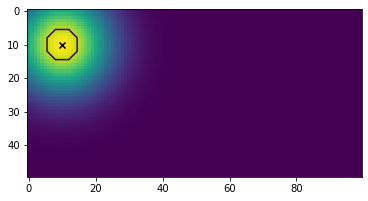

In [104]:
plt.imshow(test_data.data[0])
plt.scatter(features.where(mask_1)['hdim_2'], features.where(mask_1)['hdim_1'], color = 'black', marker = 'x')
plt.contour(mask[0], levels = [0.5])

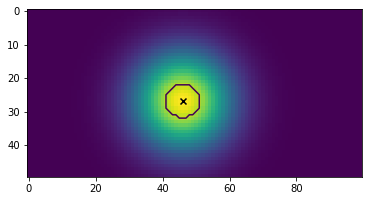

In [108]:
plt.imshow(test_data.data[20])
plt.scatter(features.where(mask_2)['hdim_2'], features.where(mask_2)['hdim_1'], color = 'black', marker = 'x')
plt.contour(mask[20], levels = [0.5])

## Trajectory linking